

<h1 style="color: red;">PRÁCTICA 6</h1>



<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">Ejercicio 1 y 2</h1>

<hr style="border: 1.5px solid orange;">



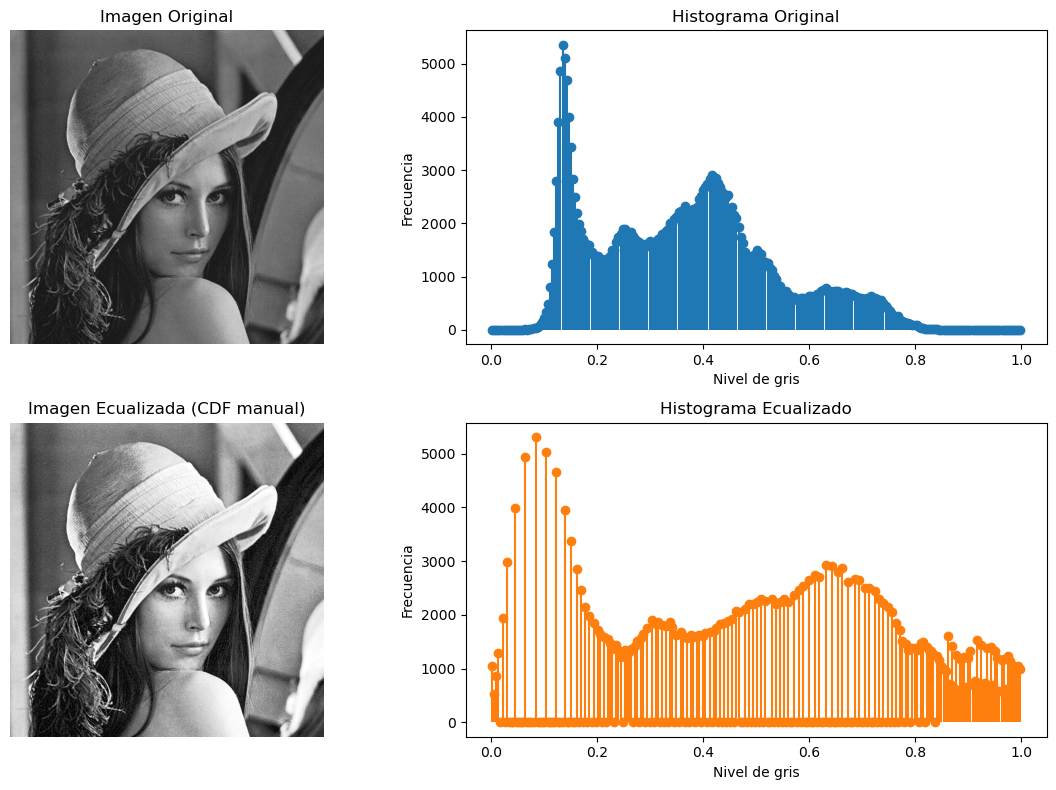

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, util
import scipy.ndimage as ndi
from scipy import signal

# Leer imagen en escala de grises y normalizar a [0,1]
imagen = io.imread('data/lena.bmp', as_gray=True)

# Parámetros de histograma
Nbins = 256
niveles = np.arange(Nbins)

# Calcular histograma original
hist, bins = np.histogram(imagen.flatten(), bins=Nbins, range=[0,1])
centers = 0.5*(bins[:-1] + bins[1:])

# Construir CDF
cdf = hist.cumsum()
cdf_norm = cdf / cdf[-1]         # Normalizada en [0,1]

# Generar la LUT de ecualización: nivel i → cdf_norm[i]
lut = cdf_norm

#  Mapear cada píxel de la imagen original
#    - Convertimos a índices enteros 0..255
idx = (imagen * (Nbins-1)).astype(np.uint8)
#    - Aplicamos la LUT
imagen_eq = lut[idx]

# Histograma de la imagen ecualizada
hist_eq, bins_eq = np.histogram(imagen_eq.flatten(), bins=Nbins, range=[0,1])
centers_eq = 0.5*(bins_eq[:-1] + bins_eq[1:])

# Representación gráfica de los resultados
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Imagen original
axs[0,0].imshow(imagen, cmap='gray')
axs[0,0].axis('off')
axs[0,0].set_title('Imagen Original')

# Histograma original
axs[0,1].stem(centers, hist, basefmt=' ', linefmt='C0-')
axs[0,1].set_title('Histograma Original')
axs[0,1].set_xlabel('Nivel de gris')
axs[0,1].set_ylabel('Frecuencia')

# Imagen ecualizada
axs[1,0].imshow(imagen_eq, cmap='gray')
axs[1,0].axis('off')
axs[1,0].set_title('Imagen Ecualizada (CDF manual)')

# Histograma ecualizado
axs[1,1].stem(centers_eq, hist_eq, basefmt=' ', linefmt='C1-')
axs[1,1].set_title('Histograma Ecualizado')
axs[1,1].set_xlabel('Nivel de gris')
axs[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">FOURIER 2D</h1>

<hr style="border: 1.5px solid orange;">

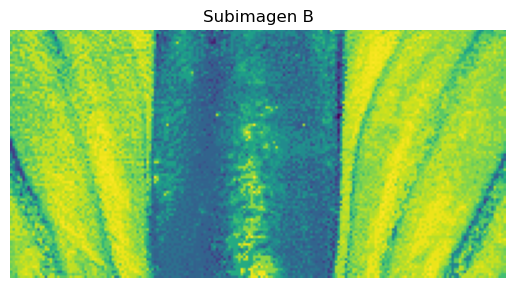

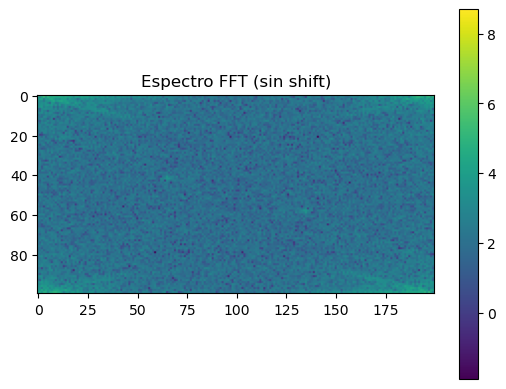

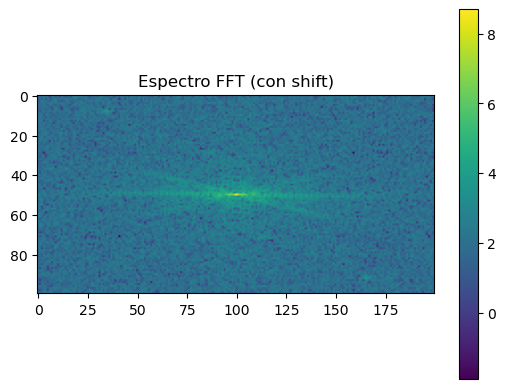

In [ ]:
# Cargar imagen en niveles de gris
Imag = io.imread('data/mandrill.tif', as_gray=True)

# Extraer subimagen B con textura clara
B = Imag[130:130+100, 150:150+200]

# 3. Calcular la FFT2 de la subimagen
F = np.fft.fft2(B)
imsize = B.size

# Mostrar la subimagen B
plt.figure()
plt.imshow(B)
plt.title('Subimagen B')
plt.axis('off')

# Mostrar espectro de potencia (escala log) sin reordenar
plt.figure()
plt.imshow(np.log10(np.abs(F)**2 / imsize))
plt.title('Espectro FFT (sin shift)')
plt.colorbar()

# Reordenar cuadrantes (frec. (0,0) al centro) y mostrar
Fshift = np.fft.fftshift(F)
plt.figure()
plt.imshow(np.log10(np.abs(Fshift)**2 / imsize))
plt.title('Espectro FFT (con shift)')
plt.colorbar()

plt.show()



En el dominio de la frecuencia, cada orientación espacial se traduce en una línea perpendicular en el plano (u,v) de la FFT. Por ejemplo, si en la imagen ves “filas” horizontales, en el espectro aparecerá una línea vertical de energía (frecuencias altas/medias a lo largo de v, bajas en u). Si ves vetas inclinadas a +30°, aparece en el espectro una línea inclinada a –60° (perpendicular).


El centro brillante indica presencia masiva de bajas frecuencias (regiones suaves, sin cambios bruscos). Las rayas horizontales (alrededor del centro) → variación preferente a lo largo de columnas (textura que cambia de arriba abajo más lentamente que de izquierda a derecha). Rayas diagonales → estructuras inclinadas en la subimagen (esas vetas curvas y casi radiales).


Las bajas frecuencias (tonos globales) concentran energía cerca del centro. Las altas frecuencias (bordes y texturas finas) se “extienden” hacia los bordes del espectro. Cada orientación espacial da lugar a una línea en el dominio de la frecuencia, orientada perpendicularmente.

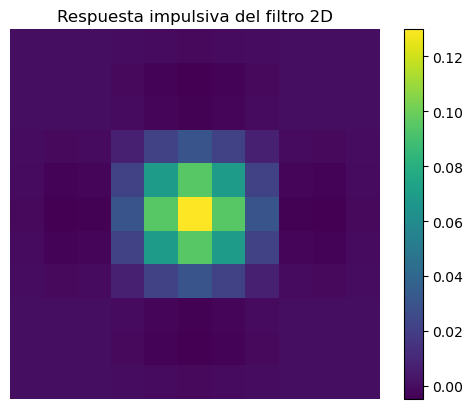

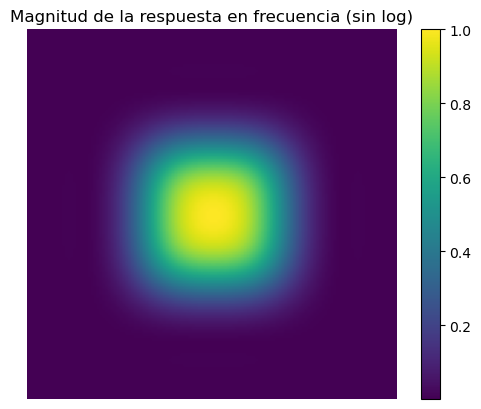

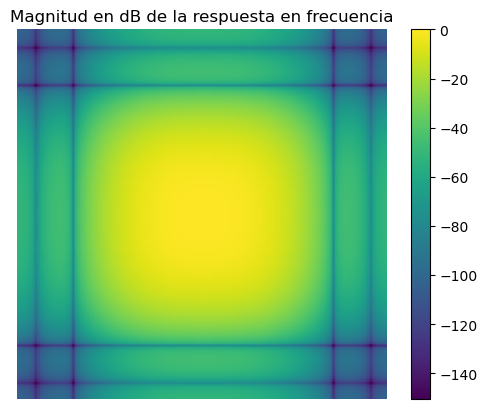

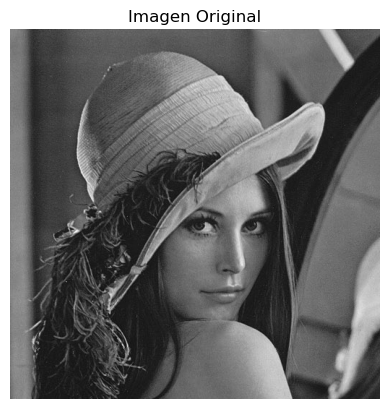

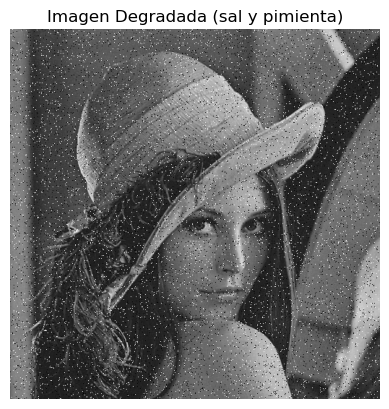

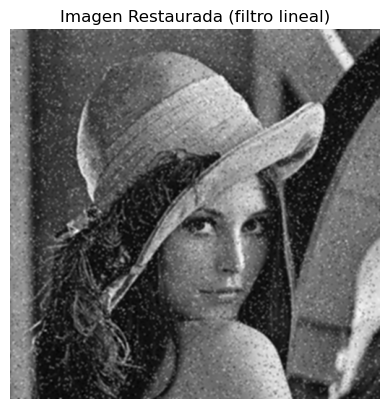

In [ ]:

# Cargar la imagen original en escala de grises
Imag = io.imread('data/lena.bmp', as_gray=True)

# Generar la imagen degradada con ruido de sal y pimienta
Jmag = util.random_noise(Imag, mode='s&p')

# Diseñar filtro FIR 1D pasabaja (orden impar Lfir=11, fc=0.18, fs=1)
Lfir = 11
fc = 0.18
Fs = 1
h_1D = signal.firwin(Lfir, fc, fs=Fs)

# Construir filtro 2D separable por producto exterior
h_2D = np.outer(h_1D, h_1D)

# Visualizar respuesta impulsiva 2D
plt.figure()
plt.imshow(h_2D)
plt.title('Respuesta impulsiva del filtro 2D')
plt.colorbar()
plt.axis('off')

# Calcular y mostrar respuesta en frecuencia del filtro
# Se paddea a 128x128 para mejor resolución
H = np.fft.fft2(h_2D, s=(128, 128))
H_shift = np.fft.fftshift(H)

plt.figure()
plt.imshow(np.abs(H_shift))
plt.title('Magnitud de la respuesta en frecuencia (sin log)')
plt.colorbar()
plt.axis('off')

plt.figure()
plt.imshow(20 * np.log10(np.abs(H_shift) + 1e-12))
plt.title('Magnitud en dB de la respuesta en frecuencia')
plt.colorbar()
plt.axis('off')

# Aplicar el filtro lineal pasabaja a la imagen degradada
J_restored = ndi.convolve(Jmag, h_2D)

# Mostrar imágenes original, degradada y restaurada
plt.figure()
plt.imshow(Imag, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

plt.figure()
plt.imshow(Jmag, cmap='gray')
plt.title('Imagen Degradada (sal y pimienta)')
plt.axis('off')

plt.figure()
plt.imshow(J_restored, cmap='gray')
plt.title('Imagen Restaurada (filtro lineal)')
plt.axis('off')

plt.show()


<hr style="border: 1.5px solid orange;">

<h1 style="color: orange;">FILTRO NO LINEAL</h1>

<hr style="border: 1.5px solid orange;">

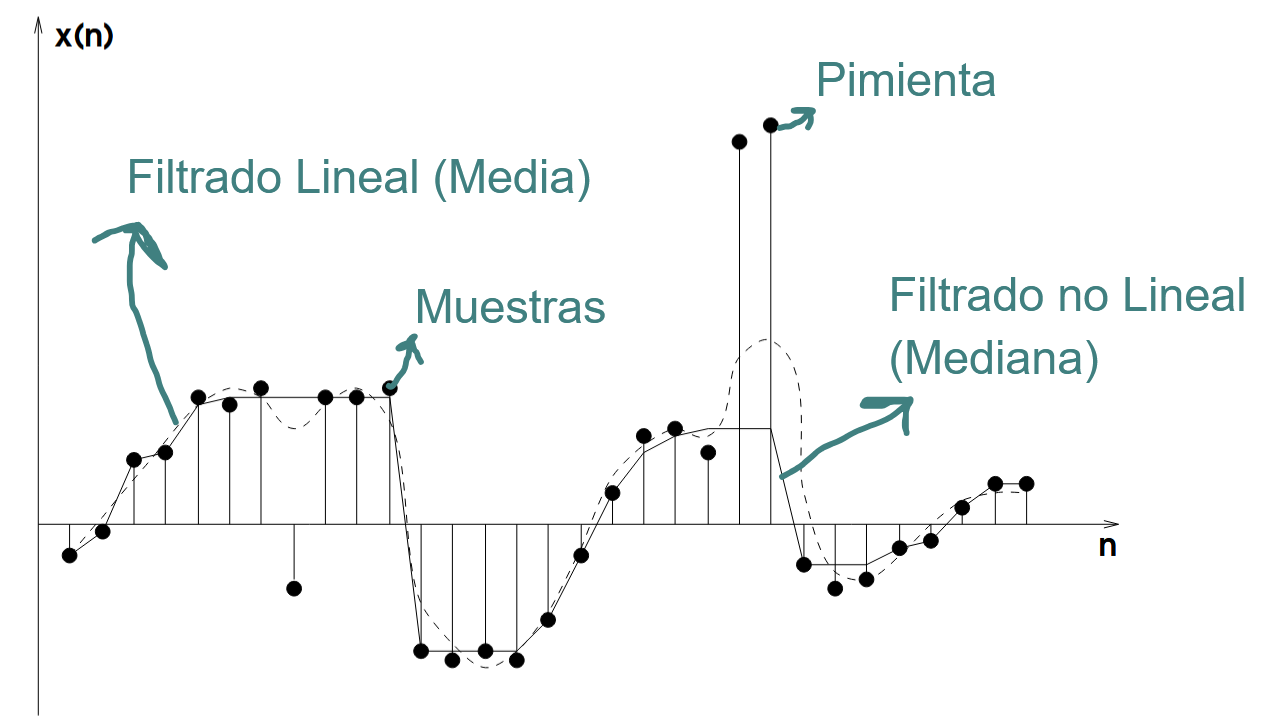

He aplicado el **filtro de mediana** de tamaño **3×3**, **5×5** y **7×7** al mismo conjunto: original → degradada → restaurada lineal. Observaciones:

* **Mediana 3×3**: elimina casi todo el ruido impulsivo “sal y pimienta” manteniendo muy bien los bordes y detalles.
* **Mediana 5×5**: refuerza la eliminación de ruido, pero empieza a suavizar ligeramente los contornos más finos.
* **Mediana 7×7**: reduce aún más el ruido, pero acentúa el suavizado de bordes y se pierden detalles pequeños (la imagen se ve más “emborronada”).

En comparación con el **filtro lineal**, la mediana 3×3 es claramente superior para este tipo de ruido, pues elimina impulsos sin difuminar las estructuras. A medida que el tamaño crece, ganamos robustez contra ruido extremo a costa de nitidez en los bordes.


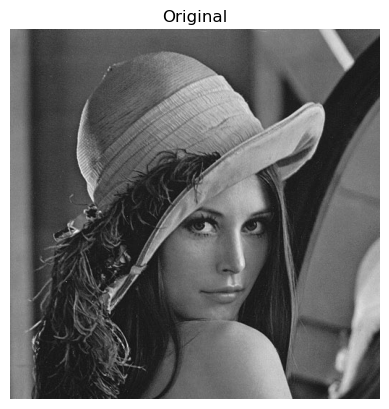

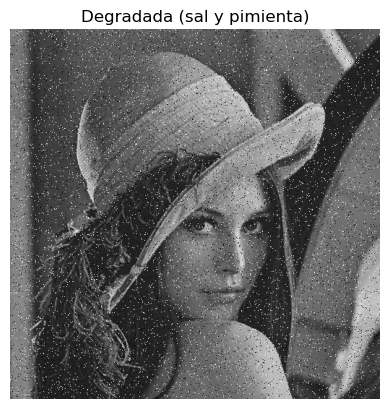

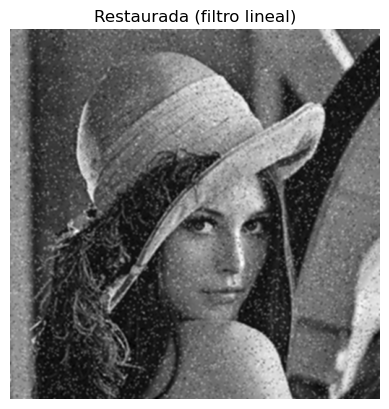

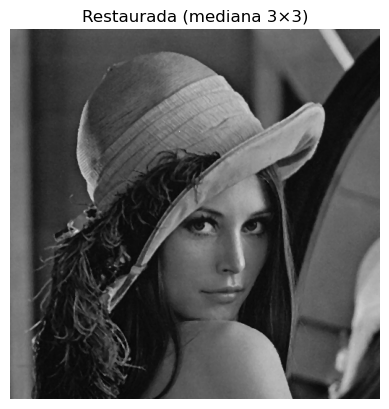

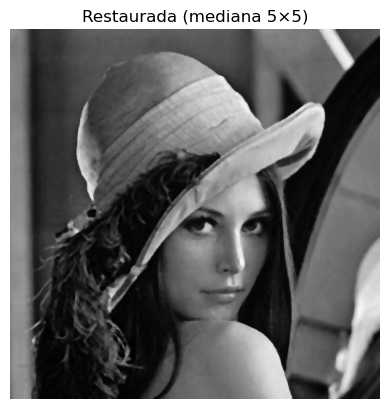

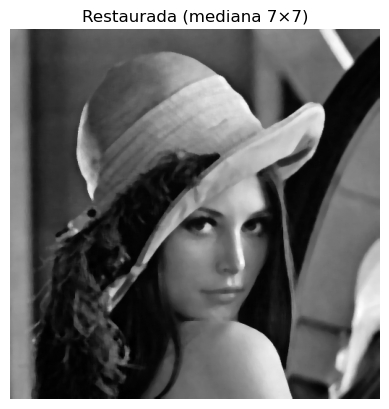

In [ ]:

# Cargar imagen original y degradada
Imag = io.imread('data/lena.bmp', as_gray=True)
Jmag = util.random_noise(Imag, mode='s&p')

# Filtro lineal para comparación
Lfir, fc, Fs = 11, 0.18, 1
h_1D = signal.firwin(Lfir, fc, fs=Fs)
h_2D = np.outer(h_1D, h_1D)
J_lin = ndi.convolve(Jmag, h_2D)

# Filtros de mediana de distintos tamaños
J_med3 = ndi.median_filter(Jmag, size=3)
J_med5 = ndi.median_filter(Jmag, size=5)
J_med7 = ndi.median_filter(Jmag, size=7)

# Mostrar cada imagen por separado
plt.figure()
plt.imshow(Imag, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.figure()
plt.imshow(Jmag, cmap='gray')
plt.title('Degradada (sal y pimienta)')
plt.axis('off')

plt.figure()
plt.imshow(J_lin, cmap='gray')
plt.title('Restaurada (filtro lineal)')
plt.axis('off')

plt.figure()
plt.imshow(J_med3, cmap='gray')
plt.title('Restaurada (mediana 3x3)')
plt.axis('off')

plt.figure()
plt.imshow(J_med5, cmap='gray')
plt.title('Restaurada (mediana 5x5)')
plt.axis('off')

plt.figure()
plt.imshow(J_med7, cmap='gray')
plt.title('Restaurada (mediana 7x7)')
plt.axis('off')

plt.show()
